## Association Rule Mining
Market Basket Analysis is one of the key techniques used by large retailers to uncover associations between items. 

It works by looking for **combinations of items that occur together frequently** in transactions. To put it another way, it allows retailers to identify relationships between the items that people buy.

##Apriori Algorithm
Apriori is an algorithm for frequent itemset mining and association rule learning over relational databases. 

It proceeds by identifying the **frequent individual items** in the database and extending them to larger and larger item sets as long as those item sets appear sufficiently often in the database. The frequent itemsets determined by Apriori can be used to determine association rules which highlight general trends in the database: this has applications in domains such as market basket analysis.
> **Support**: This says how popular an itemset is, as measured by the proportion of transactions in which an itemset appears.
> 
> **Confidence**: This says how likely item Y is purchased when item X is purchased, expressed as {X -> Y}. This is measured by the proportion of transactions with item X, in which item Y also appears.
>
> **Lift**: This says how likely item Y is purchased when item X is purchased while controlling for how popular item Y is.

In [1]:
! pip install squarify
! pip install --index-url https://test.pypi.org/simple/ PyARMViz

Looking in indexes: https://test.pypi.org/simple/
     |████████████████████████████████| 12.9MB 5.2MB/s 


In [2]:
import numpy as np
import pandas as pd 

# mlxtend will be used for market basket analysis
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
import squarify
import matplotlib
from matplotlib import style
import matplotlib.pyplot as plt
import seaborn as sns
from PyARMViz import PyARMViz
from PyARMViz.Rule import generate_rule_from_dict

sns.set()
matplotlib.rcParams['figure.figsize'] = (36, 36)
style.use('ggplot')

# 1.Loading our Groceries dataset

In [3]:
import pandas as pd

basket = pd.read_csv('https://github.com/rajeevratan84/datascienceforbusiness/blob/master/Groceries_dataset.csv?raw=true')
basket

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk
...,...,...,...
38760,4471,08-10-2014,sliced cheese
38761,2022,23-02-2014,candy
38762,1097,16-04-2014,cake bar
38763,1510,03-12-2014,fruit/vegetable juice


### Understanding our data

We have customer or member numbers, and the dates they purchased each item

In [4]:
basket['Date'] = pd.to_datetime(basket['Date'])
basket[basket['Member_number'] == 1808].sort_values(by='Date')

,Member_number,Date,itemDescription
9090,1808,2014-11-29,meat
25239,1808,2014-11-29,whole milk
11488,1808,2014-12-15,sugar
27637,1808,2014-12-15,citrus fruit
38731,1808,2014-12-15,napkins
4355,1808,2015-04-02,long life bakery product
20504,1808,2015-04-02,semi-finished bread
0,1808,2015-07-21,tropical fruit
16149,1808,2015-07-21,rolls/buns
36088,1808,2015-07-21,candy


In [5]:
# Get the items purchased for each transaction
transactions = [a[1]['itemDescription'].tolist() for a in list(basket.groupby(['Member_number','Date']))]
print(len(transactions))
transactions

14963


[['whole milk', 'pastry', 'salty snack'],
 ['sausage', 'whole milk', 'semi-finished bread', 'yogurt'],
 ['soda', 'pickled vegetables'],
 ['canned beer', 'misc. beverages'],
 ['sausage', 'hygiene articles'],
 ['sausage', 'whole milk', 'rolls/buns'],
 ['whole milk', 'soda'],
 ['frankfurter', 'soda', 'whipped/sour cream'],
 ['frankfurter', 'curd'],
 ['beef', 'white bread'],
 ['butter', 'whole milk'],
 ['frozen vegetables', 'other vegetables'],
 ['tropical fruit', 'sugar'],
 ['butter milk', 'specialty chocolate'],
 ['frozen meals', 'dental care'],
 ['rolls/buns', 'rolls/buns'],
 ['root vegetables', 'detergent'],
 ['sausage', 'rolls/buns'],
 ['dish cleaner', 'cling film/bags'],
 ['canned beer', 'frozen fish'],
 ['pip fruit', 'whole milk', 'tropical fruit'],
 ['root vegetables', 'whole milk', 'pastry'],
 ['rolls/buns', 'red/blush wine', 'chocolate'],
 ['other vegetables', 'shopping bags'],
 ['whole milk', 'chocolate', 'packaged fruit/vegetables', 'rolls/buns'],
 ['other vegetables', 'hygiene

# 2. Preparing our dataset

In [6]:
# We use TransactionEncoder from the mlxtend module to encode our date
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
te_ary

array([[False, False, False, ...,  True, False, False],
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [7]:
# Convert to a pandas datafrae
transactions = pd.DataFrame(te_ary, columns=te.columns_)
transactions

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,beverages,bottled beer,bottled water,brandy,brown bread,butter,butter milk,cake bar,candles,candy,canned beer,canned fish,canned fruit,canned vegetables,cat food,cereals,chewing gum,chicken,chocolate,chocolate marshmallow,citrus fruit,cleaner,cling film/bags,cocoa drinks,coffee,condensed milk,cooking chocolate,cookware,cream,cream cheese,...,salt,salty snack,sauces,sausage,seasonal products,semi-finished bread,shopping bags,skin care,sliced cheese,snack products,soap,soda,soft cheese,softener,soups,sparkling wine,specialty bar,specialty cheese,specialty chocolate,specialty fat,specialty vegetables,spices,spread cheese,sugar,sweet spreads,syrup,tea,tidbits,toilet cleaner,tropical fruit,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14958,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,F

### And now we create item purhcase counts from our transaction data

In [8]:
pf = transactions.describe()
f = pf.iloc[0]-pf.iloc[3]
a = f.tolist()
b = list(f.index)
item = pd.DataFrame([[a[r],b[r]]for r in range(len(a))], columns=['Count','Item'])
item = item.sort_values(['Count'], ascending=False).head(50)
item

,Count,Item
164,2363,whole milk
102,1827,other vegetables
122,1646,rolls/buns
138,1453,soda
165,1285,yogurt
123,1041,root vegetables
156,1014,tropical fruit
12,908,bottled water
130,903,sausage
30,795,citrus fruit


### Now let's visualize the 167 items as a Treemap

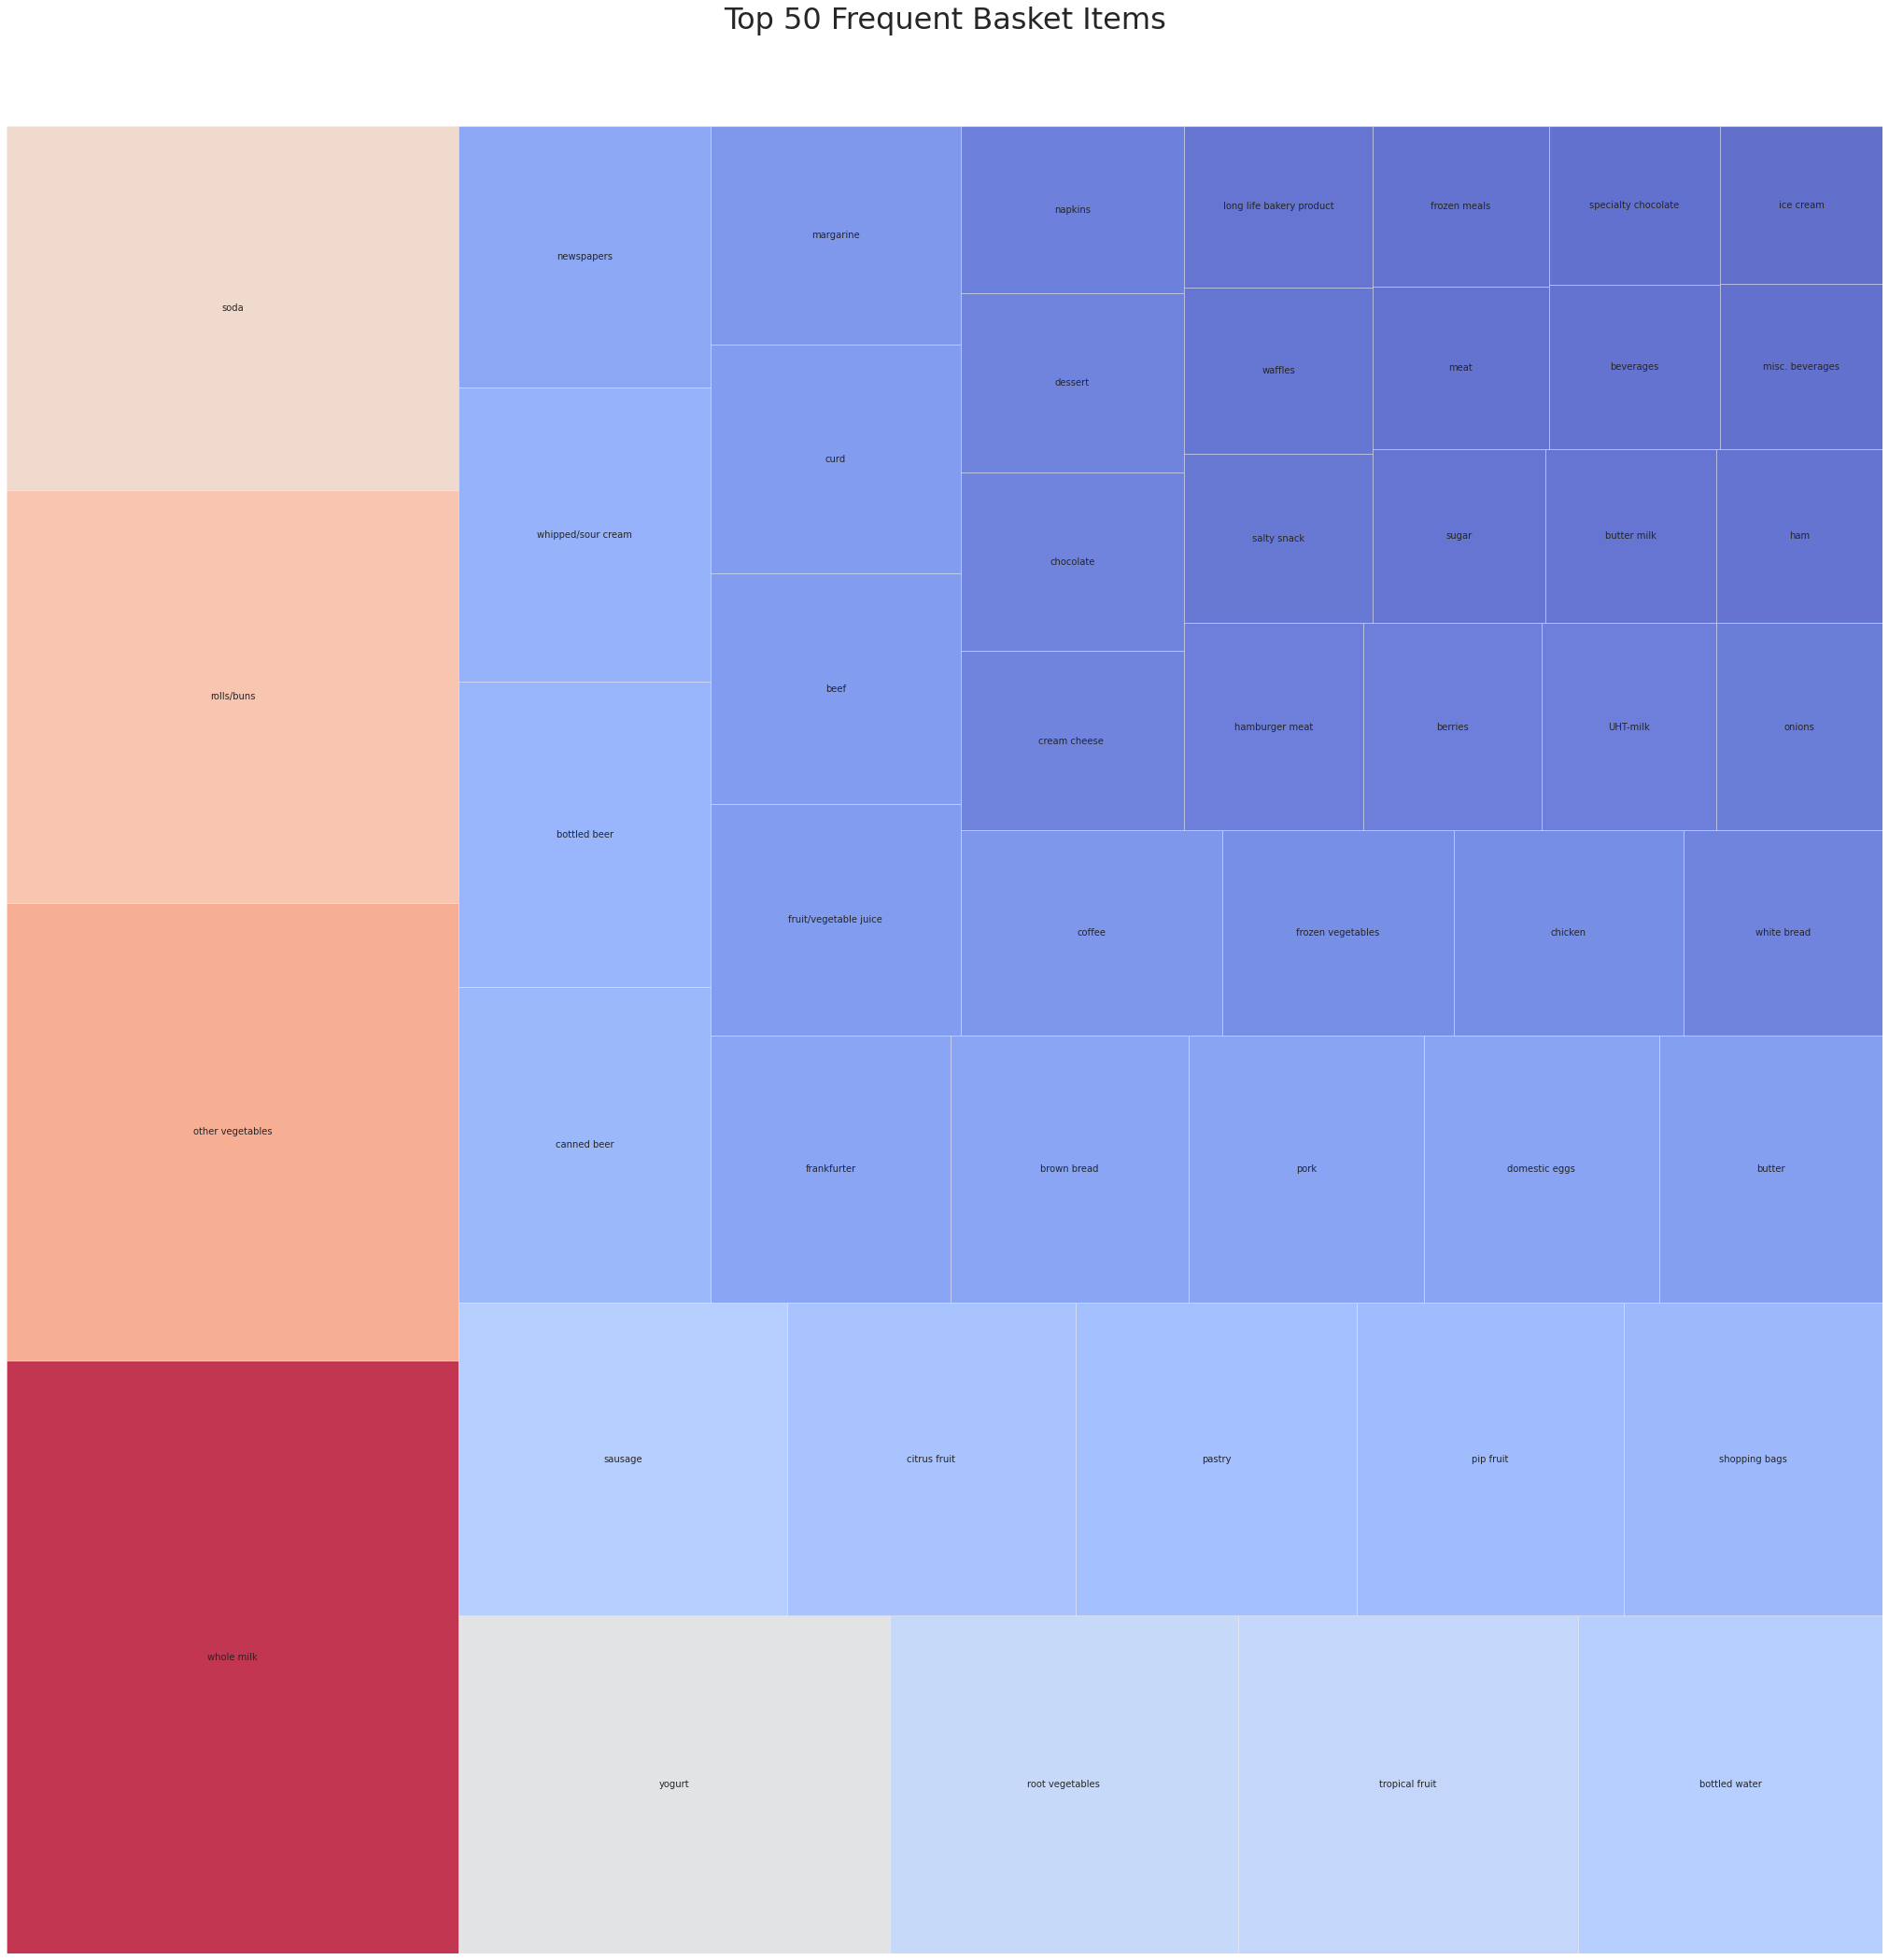

In [9]:
fig, ax = plt.subplots()

# set color scheme
cmap = matplotlib.cm.coolwarm

# Get upper and lower boudns for the color mapping
mini = min(item["Count"])
maxi = max(item["Count"])

# Set out color mapping limits 
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)

# Obtain our raw colors 
colors = [cmap(norm(value)) for value in item["Count"]]

# Create the TreeMap plot with Squarify
squarify.plot(sizes=item["Count"], label=item["Item"], alpha=0.8, color=colors)
plt.axis('off')
plt.title("Top 50 Frequent Basket Items", fontsize=32)
ttl = ax.title
ttl.set_position([.5, 1.05])


## Let's find our Frequent Itemsets using our Apriori Module
We set the minimum support to 0.001 and maxlen of our itemset to be 5

In [10]:
frequent_itemsets = apriori(transactions, min_support=0.001, use_colnames=True, max_len=5)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets.head(50)

,support,itemsets,length
0,0.004010,(Instant food products),1
1,0.021386,(UHT-milk),1
2,0.001470,(abrasive cleaner),1
3,0.001938,(artif. sweetener),1
4,0.008087,(baking powder),1
5,0.001136,(bathroom cleaner),1
6,0.033950,(beef),1
7,0.021787,(berries),1
8,0.016574,(beverages),1
9,0.045312,(bottled beer),1


### The above table gives all association rules for basket analysis

In [11]:
b = association_rules(frequent_itemsets, metric="lift", min_threshold=0.001)
b['uni'] = np.nan
b['ant'] = np.nan
b['con'] = np.nan
b['tot'] = 14963

## Now let's create some illustrative plots

In [12]:
transactions = [a[1]['itemDescription'].tolist() for a in list(basket.groupby(['Member_number','Date']))]

def trans():
    for t in transactions:
        yield t
    
def ant(x):
    cnt = 0
    for t in trans():
        t = set(t)
        if x.intersection(t) == x:
            cnt = cnt + 1 
    return cnt

bb = b.values.tolist()  

In [13]:
rules_dict = []
for bbb in bb:
    bbb[10] = ant(bbb[0])
    bbb[11] = ant(bbb[1])
    bbb[9] = ant(bbb[0].union(bbb[1]))
    diction = {
        'lhs': tuple(bbb[0]), 
        'rhs': tuple(bbb[1]),
        'count_full': bbb[9],
        'count_lhs': bbb[10],
        'count_rhs': bbb[11],
        'num_transactions': bbb[12]
    }
    rules_dict.append(diction)


In [14]:
rules = []
for rd in rules_dict: 
    rules.append(generate_rule_from_dict(rd))

### Here we illustrate our itemset relationships

**Antecedent and Consequent**

The IF component of an association rule is known as the antecedent. The THEN component is known as the consequent. The antecedent and the consequent are disjoint; they have no items in common.

In [15]:
PyARMViz.generate_parallel_category_plot(rules)